In [1]:
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
import matplotlib.pylab as plt
import os

In [2]:
path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list_orig = os.listdir(image_path)
image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in image_list_orig]

In [3]:
IMG_HEIGHT = 192
IMG_WIDTH = 256
N_CHANNELS = 3
EPOCHS = 20
BUFFER_SIZE = 1000
BATCH_SIZE = 8
DATASET_SIZE = len(image_list_orig)

In [4]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

In [5]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH), method='nearest')
    input_mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH), method='nearest')

    return input_image, input_mask

In [6]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(192, 256, 1)


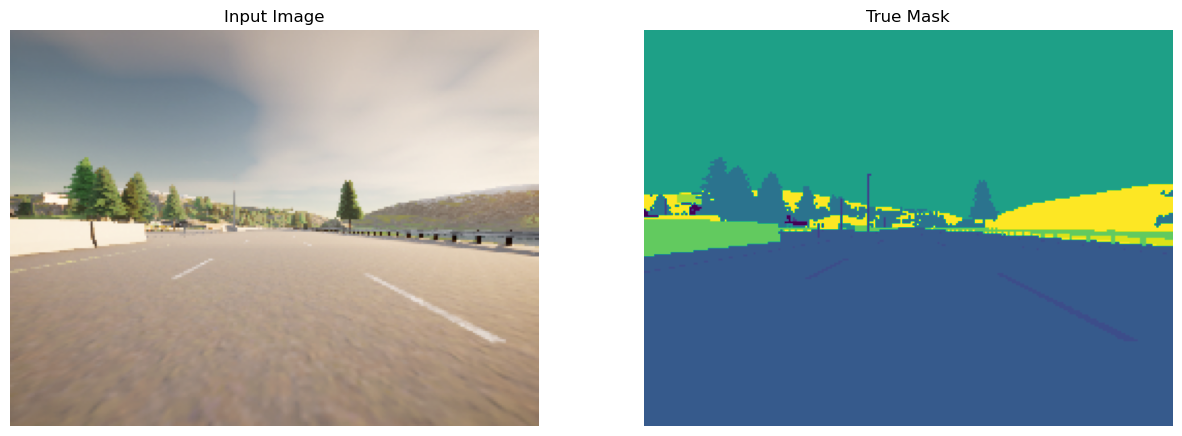

In [7]:
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [8]:
train_size = int(0.9 * DATASET_SIZE)
train_dataset = processed_image_ds.take(train_size)
val_dataset = processed_image_ds.skip(train_size)

In [9]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters,
                  (3,3),     
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters,
                  (3,3),
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
                 
    if max_pooling:
        next_layer = MaxPooling2D((2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [10]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(n_filters,
                         (3,3),
                         strides=(2,2),
                         padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)

    conv = Conv2D(n_filters,
                 (3,3),
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 
                 (3,3), 
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)    
    return conv

In [11]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.5)
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob=0.5, max_pooling=False) 

    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes,(1, 1) , padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [12]:
unet = unet_model((IMG_HEIGHT, IMG_WIDTH, N_CHANNELS))
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 192, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 192, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [13]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


print(processed_image_ds.element_spec)

with tf.device('/device:gpu:0'):
    model_history = unet.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

(TensorSpec(shape=(192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(192, 256, 1), dtype=tf.uint8, name=None))
Epoch 1/20
120/120 [==============================] - 61s 292ms/step - loss: 1.0641 - accuracy: 0.6957 - val_loss: 0.6116 - val_accuracy: 0.8421
Epoch 2/20
120/120 [==============================] - 25s 209ms/step - loss: 0.4492 - accuracy: 0.8765 - val_loss: 0.5852 - val_accuracy: 0.8339
Epoch 3/20
120/120 [==============================] - 25s 210ms/step - loss: 0.3481 - accuracy: 0.8997 - val_loss: 0.4908 - val_accuracy: 0.8557
Epoch 4/20
120/120 [==============================] - 25s 212ms/step - loss: 0.2678 - accuracy: 0.9211 - val_loss: 0.4486 - val_accuracy: 0.8679
Epoch 5/20
120/120 [==============================] - 26s 214ms/step - loss: 0.2462 - accuracy: 0.9281 - val_loss: 0.3971 - val_accuracy: 0.8875
Epoch 6/20
120/120 [==============================] - 26s 215ms/step - loss: 0.2019 - accuracy: 0.9407 - val_loss: 0.3961 - val_accuracy: 0.8805
Epoch 7

<Figure size 640x480 with 0 Axes>

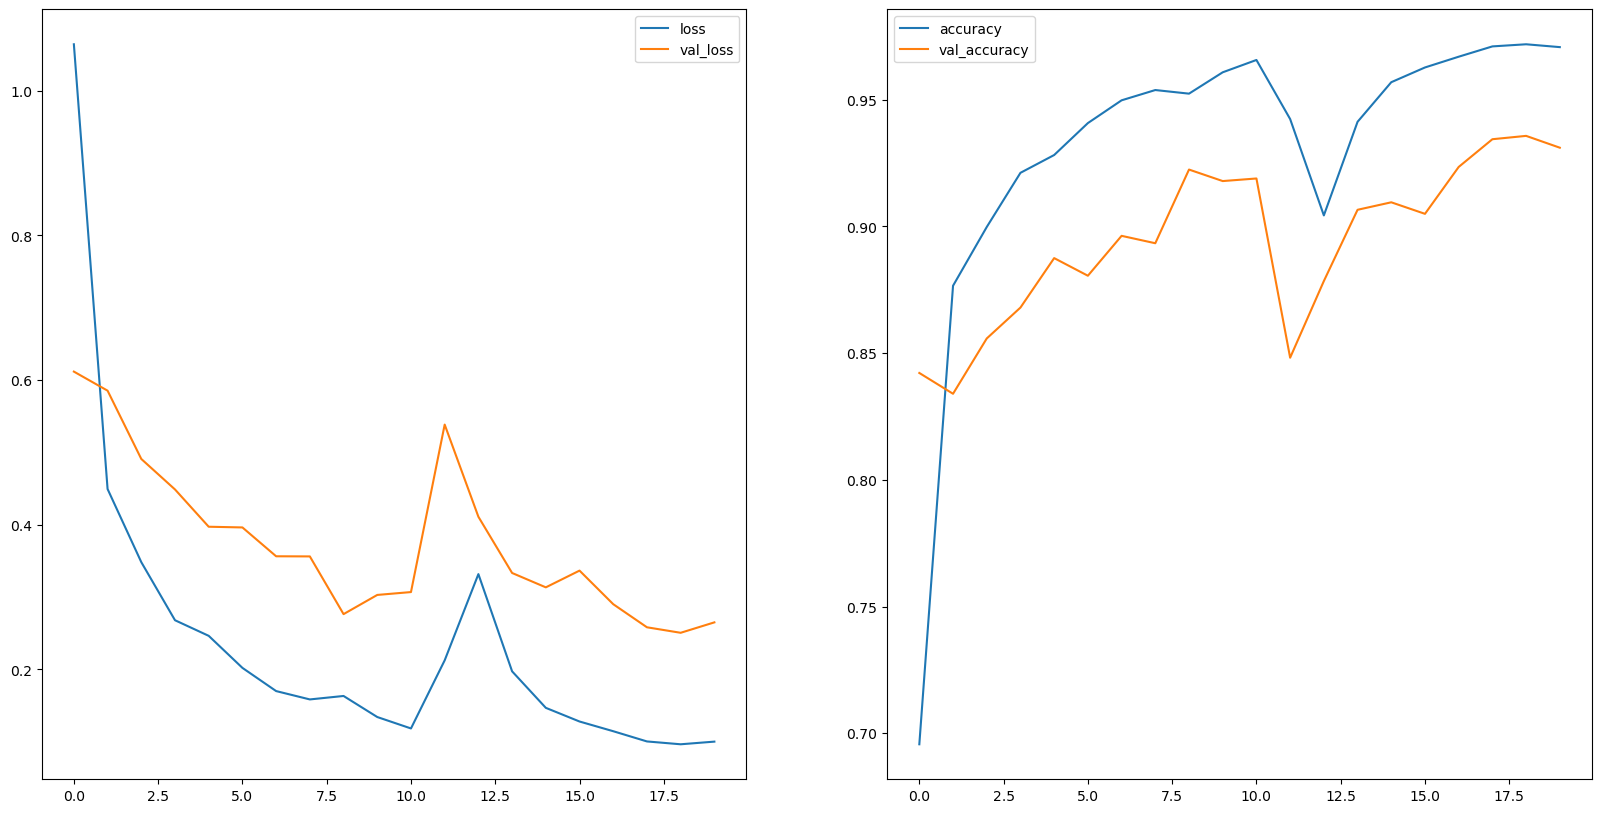

In [16]:
plt.tight_layout()
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1); plt.plot(model_history.history['loss'], label='loss'); plt.plot(model_history.history['val_loss'], label='val_loss'); plt.legend()
plt.subplot(1, 2, 2); plt.plot(model_history.history['accuracy'], label='accuracy'); plt.plot(model_history.history['val_accuracy'], label='val_accuracy'); plt.legend()

In [17]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 229ms/step


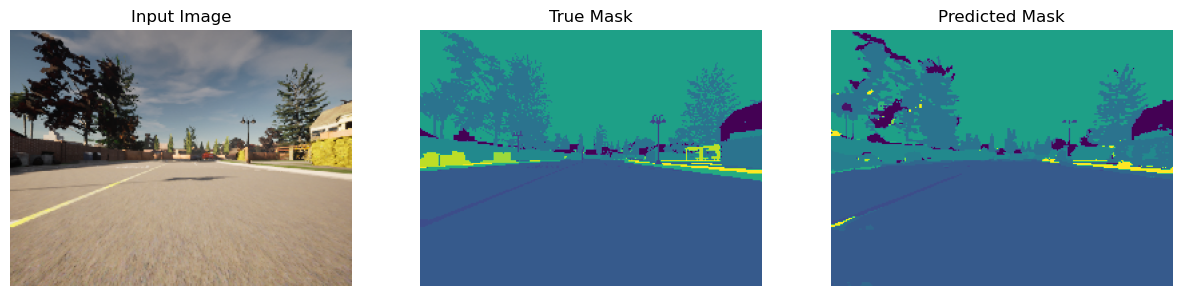

1/1 [==============================] - 0s 201ms/step


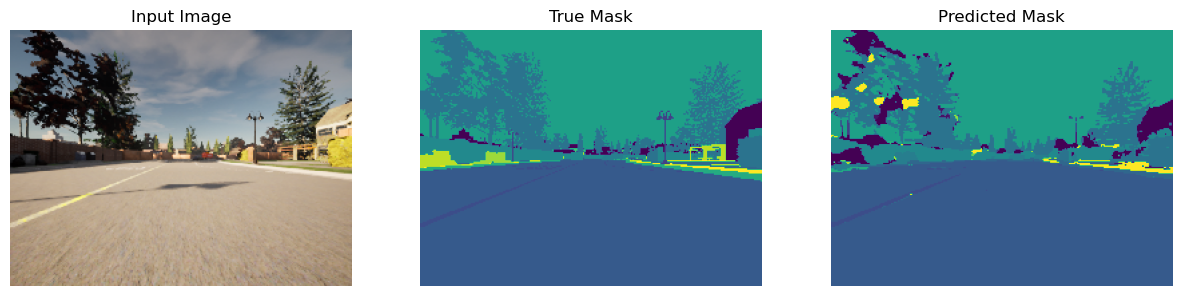

1/1 [==============================] - 0s 207ms/step


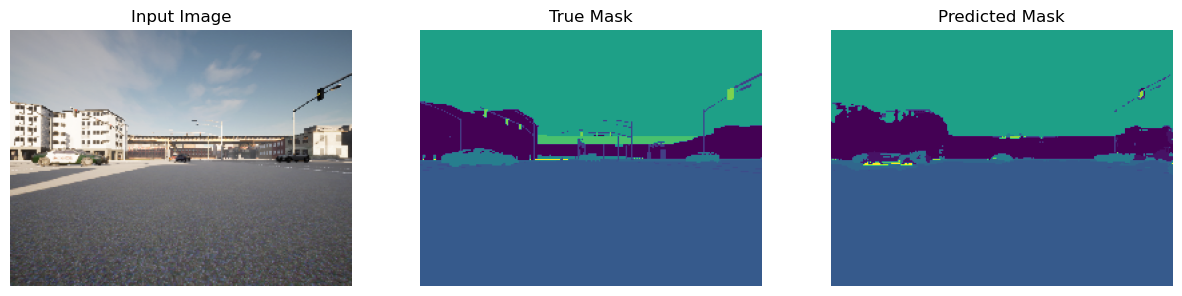

1/1 [==============================] - 0s 194ms/step


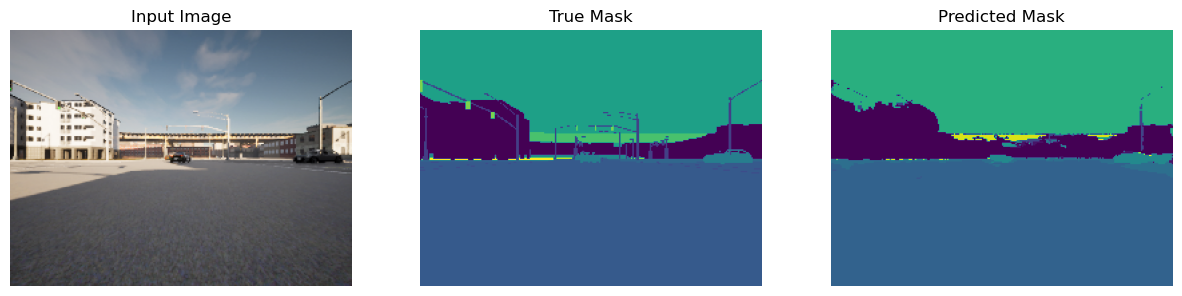

1/1 [==============================] - 0s 202ms/step


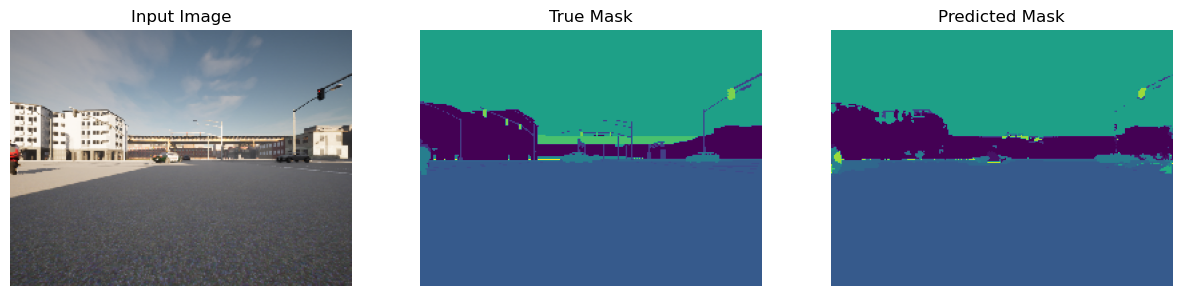

1/1 [==============================] - 0s 202ms/step


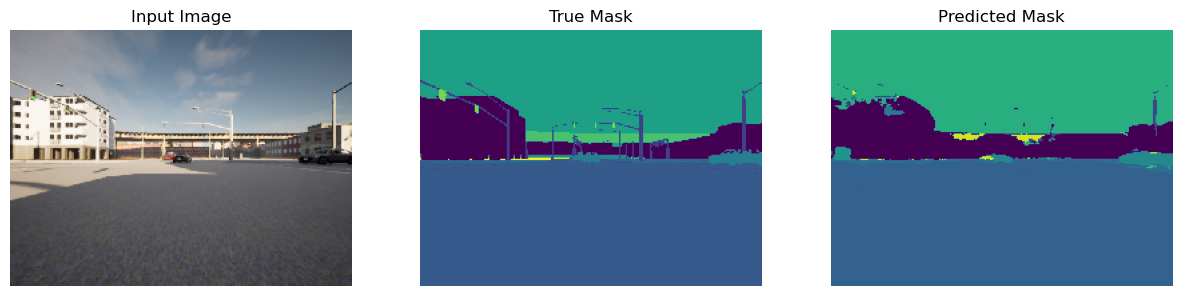

In [19]:
show_predictions(val_dataset, 6)